In [1]:
library(purrr)
library(dplyr)
library(corrplot)
library(hablar)
library(RColorBrewer)
library(MASS)
library(stats)
library(caTools)
library(tidyr)
library(ranger)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

corrplot 0.84 loaded

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



In [2]:
train = read.csv("train.csv")
train['train_or_test'] = 'train'
test = read.csv("test.csv")
test['train_or_test'] = 'test'

In [3]:
train_target <- train[c('Id', "SalePrice")]
train <- train[names(train) != 'SalePrice']
al <- rbind(train, test)

In [4]:
desc <- function (variable){
    if (is.numeric(al[[variable]])){
            hist(al[[variable]], xlab = "", main = paste("Histogram of ", toupper(variable)))
    }
    
    else if (is.character(al[[variable]]) | is.factor(al[[variable]])){
            barplot(prop.table(table(al[[variable]])), main = paste("Barplot of ", toupper(variable)))    
        }
    }

In [5]:
# data.frame(colSums(is.na(al)))
NAs <- al %>%
    map_df(function(x) sum(is.na(x))) %>%
    gather(feature, num_nulls)  %>% 
    mutate(Na_ratio = round(num_nulls / nrow(al), 4))
NAs <- NAs[NAs$num_nulls != 0,]          
(NAs <- NAs[order(NAs$num_nulls, decreasing = T), ])

feature,num_nulls,Na_ratio
PoolQC,2909,0.9966
MiscFeature,2814,0.9640
Alley,2721,0.9322
Fence,2348,0.8044
FireplaceQu,1420,0.4865
LotFrontage,486,0.1665
GarageYrBlt,159,0.0545
GarageFinish,159,0.0545
GarageQual,159,0.0545
GarageCond,159,0.0545


In [6]:
# in variables desription file, we see that some Na has meaning, so we replace Na's by that value
al$Alley <- ifelse(is.na(al$Alley), "No alley access", al$Alley)
al$BsmtQual <- ifelse(is.na(al$BsmtQual), "No Basement", al$BsmtQual)
al$BsmtQual <- ifelse(is.na(al$BsmtQual), "No Basement", al$BsmtQual)
al$BsmtCond <- ifelse(is.na(al$BsmtCond), "No Basement", al$BsmtCond)
al$BsmtExposure <- ifelse(is.na(al$BsmtExposure), "No Basement", al$BsmtExposure)
al$BsmtFinType1 <- ifelse(is.na(al$BsmtFinType1), "No Basement", al$BsmtFinType1)
al$BsmtFinType2 <- ifelse(is.na(al$BsmtFinType2), "No Basement", al$BsmtFinType2)
al$FireplaceQu <- ifelse(is.na(al$FireplaceQu), "No Fireplace", al$FireplaceQu)
al$GarageType <- ifelse(is.na(al$GarageType), "No Garage", al$GarageType)
al$GarageQual <- ifelse(is.na(al$GarageQual), "No Garage", al$GarageQual)
al$GarageFinish <- ifelse(is.na(al$GarageFinish), "No Garage", al$GarageFinish)
al$GarageCond <- ifelse(is.na(al$GarageCond), "No Garage", al$GarageCond)
al$PoolQC <- ifelse(is.na(al$PoolQC), "No Pool", al$PoolQC)
al$Fence <- ifelse(is.na(al$Fence), "No Fence", al$Fence)
al$MiscFeature <- ifelse(is.na(al$MiscFeature), "None", al$MiscFeature)

In [7]:
# Now we check again NA's
NAs <- al %>%
    map_df(function(x) sum(is.na(x))) %>%
    gather(feature, num_nulls)  %>% 
    mutate(Na_ratio = round(num_nulls / nrow(al), 4))
NAs <- NAs[NAs$num_nulls != 0,]          
(NAs <- NAs[order(NAs$num_nulls, decreasing = T), ])

feature,num_nulls,Na_ratio
LotFrontage,486,0.1665
GarageYrBlt,159,0.0545
MasVnrType,24,0.0082
MasVnrArea,23,0.0079
MSZoning,4,0.0014
Utilities,2,0.0007
BsmtFullBath,2,0.0007
BsmtHalfBath,2,0.0007
Functional,2,0.0007
Exterior1st,1,0.0003


In [8]:
# Let us fill NA's, in nemarice variables with mean, and in catagorical variables with most frequent
for (variable in NAs$feature){
    if (is.numeric(al[[variable]])){
        al[variable][is.na(al[variable])] <- mean(al[[variable]], na.rm = TRUE)
    }
    else if (is.character(al[[variable]]) | is.factor(al[[variable]])){
        al[is.na(al[variable]),][variable] <- names(which.max(table(al[variable])))
    }
    }
    

In [9]:
# Now finally we check NA's
sum(is.na(al))

[1] 0

In [10]:
# # Now we visulize each 
# for (i in seq(1,ncol(al)-1,2)){
#     par(mfrow=c(2, 2))
#     desc(names(al[i]))
#     desc(names(al[i+1]))
# }

In [11]:
a <- data.frame(sapply(al, class))
names(a) <- c("class")
a

,class
Id,integer
MSSubClass,integer
MSZoning,factor
LotFrontage,numeric
LotArea,integer
Street,factor
Alley,character
LotShape,factor
LandContour,factor
Utilities,factor


In [12]:
a %>%
    group_by(class) %>% 
    tally()

class,n
character,15
factor,29
integer,26
numeric,11


In [15]:
train <- al[al$train_or_test == 'train',]
train <- train[ , -which(names(train) == 'train_or_test')]
train <- merge(train, train_target, by = 'Id')
test <- al[al$train_or_test == 'test',]
test <- test[ , -which(names(test) == 'train_or_test')]
# sample <- sample.split(data$SalePrice, SplitRatio = 0.65) 
# train <- subset(data, sample == TRUE)
# test <- subset(data, sample == FALSE)

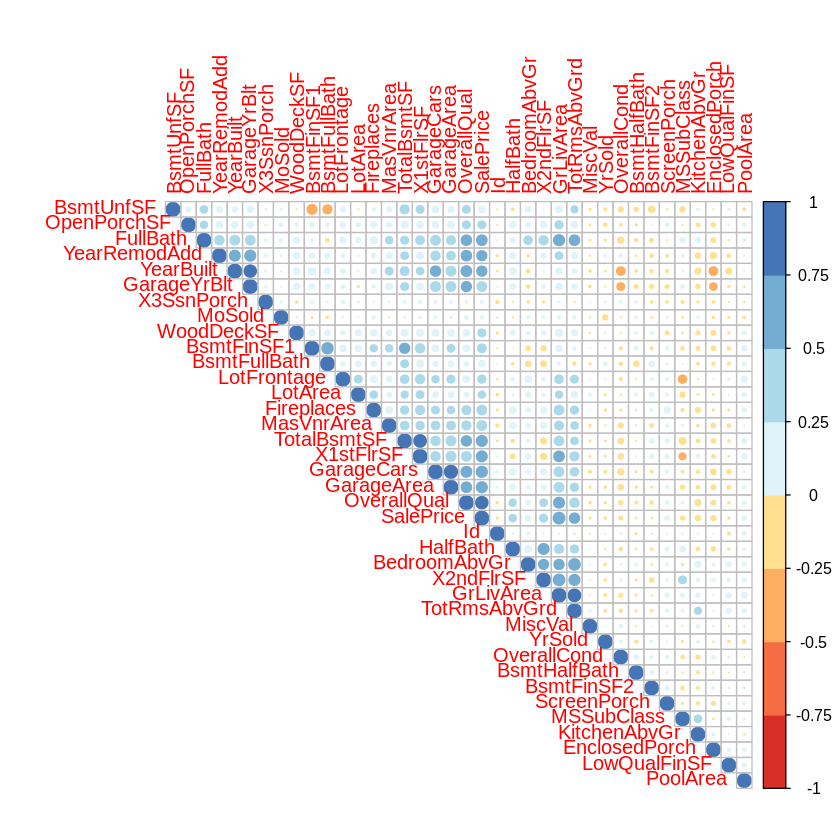

In [16]:
corrplot(cor(train %>% keep(is.numeric)), type="upper", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))

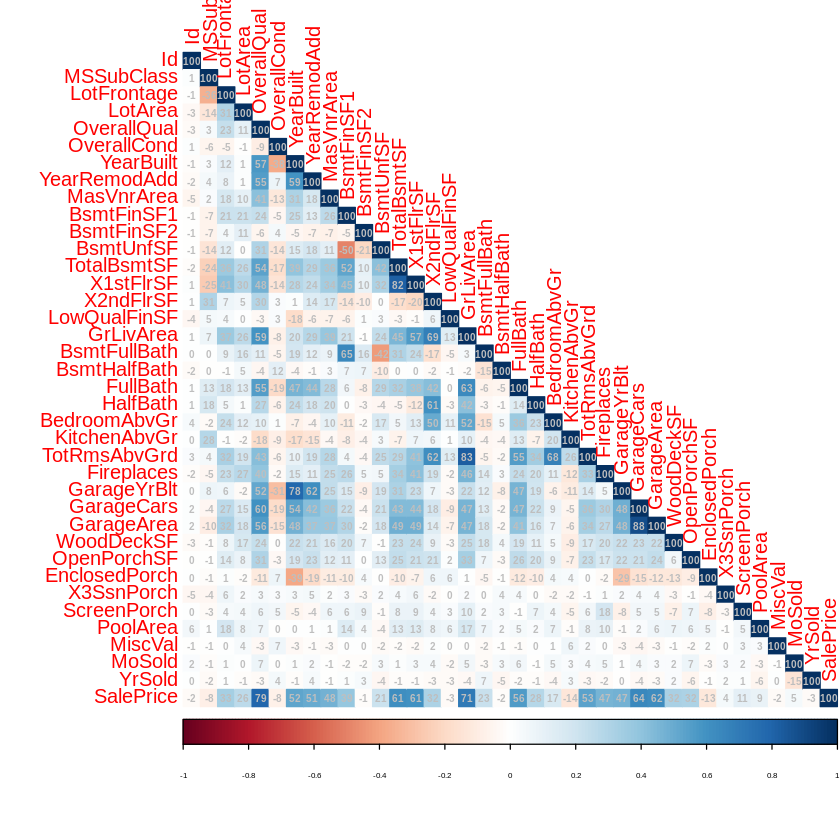

In [17]:
cex.before <- par("cex")
par(cex = 0.5)
corrplot(cor(train %>% keep(is.numeric)), insig = "blank", method = "color",
    addCoef.col="grey", type='lower',
    tl.cex = 1/par("cex"), addCoefasPercent = TRUE)
par(cex = cex.before)

In [18]:
# # check if case to lower reduce number of unique values
for (i in names(train %>% keep(is.character))){
    if (all(table(train[[i]]) == table(tolower(train[[i]])))== FALSE){
        print(i)
    }
}

In [19]:
lm1 <- lm(SalePrice ~ ., data=train)
names(which.min(summary(lm1)$coefficients[,4]))

[1] "RoofMatlWdShngl"

In [20]:
a = data.frame(summary(lm1)$coefficients)
a[order(a$Pr...t..),]

,Estimate,Std..Error,t.value,Pr...t..
RoofMatlWdShngl,6.302536e+05,5.365013e+04,11.747477,3.007024e-30
X2ndFlrSF,6.234664e+01,5.689444e+00,10.958303,1.047684e-26
RoofMatlCompShg,5.753007e+05,5.269143e+04,10.918297,1.565150e-26
RoofMatlMembran,6.706055e+05,6.255077e+04,10.720979,1.113893e-25
RoofMatlWdShake,5.673234e+05,5.503756e+04,10.307930,6.165993e-24
RoofMatlMetal,6.390603e+05,6.217448e+04,10.278500,8.167103e-24
RoofMatlTar&Grv,5.761991e+05,5.648257e+04,10.201363,1.700745e-23
RoofMatlRoll,5.620058e+05,5.828755e+04,9.641952,3.029569e-21
Condition2PosN,-2.389383e+05,2.758681e+04,-8.661321,1.471955e-17
X1stFlrSF,4.413243e+01,5.636406e+00,7.829889,1.062756e-14


In [ ]:
# Automated variable selection
fit <- lm(formula = SalePrice ~ ., data = train)
automate_variable_selection <- stepAIC(fit, direction="both", trace=0)

In [31]:
only_significat_vars <- names(automate_variable_selection$contrasts)

In [32]:
final_df <- train[only_significat_vars]
dim(final_df)

[1] 1079   20

In [33]:
lm3 <- lm(SalePrice ~ ., data = cbind(final_df, train["SalePrice"]))
summary(lm3)


Call:
lm(formula = SalePrice ~ ., data = cbind(final_df, train["SalePrice"]))

Residuals:
    Min      1Q  Median      3Q     Max 
-141928  -19522    -629   16184  210192 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)               407570      57248   7.119 2.11e-12 ***
StreetPave                 23348      18187   1.284 0.199513    
LandContourHLS             14742       9432   1.563 0.118389    
LandContourLow              3293      12869   0.256 0.798060    
LandContourLvl             13826       6955   1.988 0.047111 *  
LotConfigCulDSac           15557       5772   2.695 0.007151 ** 
LotConfigFR2              -15902       7247  -2.194 0.028458 *  
LotConfigFR3              -22595      22689  -0.996 0.319577    
LotConfigInside            -1817       3256  -0.558 0.576895    
LandSlopeMod               15378       7613   2.020 0.043653 *  
LandSlopeSev               22094      16387   1.348 0.177896    
NeighborhoodBlueste       -14514

In [35]:
pred <- predict(lm3, newdata = test)

ERROR: Error in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels): factor RoofMatl has new levels ClyTile, Roll


In [ ]:
average_inherit_error <- (mean(test$SalePrice)^2)
MSE_LM <- sum((test$SalePrice - pred)^2)/nrow(test)

In [ ]:
write.csv(cbind('Id'=test$Id, 'SalePrice'=pred), "submission_Linear_regression.csv", row.names=FALSE)

# <center><font color='red' size='10'>Random forest</font>

In [ ]:
library(ranger)
rf1 <- ranger( 
            formula   = SalePrice ~ .,  
            data      = train, 
            num.trees = 1000,  
            num.threads = 100,  
            min.node.size = 2, 
            classification = F,
            mtry = floor(sqrt(ncol(train)))) 
pred_rf1 <- predict(rf1, test)
MSE_RF <- (sum(test$SalePrice - pred_rf1$predictions)^2)/nrow(test)
print(paste("MSE_LM: ", MSE_LM/100000000))
print(paste("MSE_RF: ", MSE_RF/100000000))

In [ ]:
# as we see here, Liner regression have very low MSE compaired to MSE obtained from Random forest model

# <font color='red'>standrization numeric variables</font>

In [ ]:
# standrization numeric variables
scaled.dat <- scale(train[!names(train) == "SalePrice"] %>% keep(is.numeric))
train[names(data.frame(scaled.dat))] = data.frame(scaled.dat)
head(train)

In [ ]:
# Automated variable selection
# fit <- lm(formula = SalePrice ~ ., data = train) 
# automate_variable_selection <- stepAIC(fit, direction="both", trace=0)
only_significat_vars <- names(automate_variable_selection$contrasts)
final_df <- train[only_significat_vars]
# dim(final_df)
lm3_standrised <- lm(SalePrice ~ ., data= cbind(final_df, train["SalePrice"]))
# summary(lm3)
pred <- predict(lm3_standrised, newdata = test)
average_inherit_error <- (mean(test$SalePrice)^2)
(MSE_LM_standrised <- sum((test$SalePrice - pred)^2)/nrow(test))

In [41]:

rf1_standrised <- ranger( 
            formula   = SalePrice ~ .,  
            data      = train, 
            num.trees = 1000,  
            num.threads = 100,  
            min.node.size = 2, 
            classification = F,
            mtry = floor(sqrt(ncol(train)))) 
pred_rf1_standrised <- predict(rf1_standrised, test)
MSE_RF_standrised <- (sum(test$SalePrice - pred_rf1_standrised$predictions)^2)/nrow(test)
# print(paste("MSE_LM_standrised: ", MSE_LM_standrised/100000000))
print(paste("MSE_RF_standrised: ", MSE_RF_standrised/100000000))

[1] "MSE_RF_standrised:  144.381028750899"


In [ ]:
head(cbind(scale(train[!names(train) == "SalePrice"] %>% keep(is.numeric)), train$SalePrice))